# Image Processing for Machine Learning

*Author: Charles (Charlie) Rice for Break Through Tech*

---
Working with images is one of the biggest challenges in learning machine learning. They are a fundamentally different datatype from the tabular (row-and-column) datasets you worked with in your *Machine Learning Foundations* course. Even the introductory lessons that discuss the workings of convolutional neural networks (CNNs or ConvNets) smooth over the challenges of actually working with images.

Image data presents three main challenges. First, they tend to be very large datasets, measured in gigabytes, and therefore it can be challenging to read them immediately into memory like most of the data we work with. Second, the labels associated with them for classification are seldom easily attached; they usually have to be pulled out of some other source and prepared. And third, because the labels are often separate, the exploratory data process tends to happen on two different pieces of data: the labels and the images themselves.

In this lesson, we will present in depth two main workflows for working with images, representing two different kinds of problem: simple classification and multi-label classification (which is different from multi-class classification).

**NOTE:** Many times when working with neural networks, we can walk away from the computer when we start to actually train the model. Epochs take time, after all. If you're running this in Colab, you don't have that luxury. Colab will fail quietly and requires fairly consistent monitoring. (There's a tab in the upper right corner of the screen that monitors system resources. It's recommended that you open this tab and keep it open during training.)

# Learning Objectives

By the end of this lesson, you will be able to:

1.   Identify some of the challenges of working with image data
2.   Execute a workflow to handle those challenges



# Acknowledgments
Simple Classification is adapted from Francois Chollet's "[Image Classification from Scratch](https://keras.io/examples/vision/image_classification_from_scratch/)" in the official Keras Tutorials. Multi-label classification is adapted from several competition [notebooks on Kaggle](https://www.kaggle.com/datasets/raman77768/movie-classifier/code).

# Image Processing: Simple Classification

There are several classes of problem that image data lends itself to: classification, segmentation, object detection, and, more recently, generative AI (think DALL-E). These challenges scale in complexity as we add elements to the problem, like time. That is, doing computer vision on video data, which is images over time, is significantly more challenging than doing it on still iamges.

We are going to focus on the basics and look at two flavors of classification: simple classification and multi-label classification. Simple classification can be binary like identifying whether an image is a cat or a dog (or, even simpler, dog or not-dog). It can be multi-class, such as identifying particular makes or models of automobiles. Image classification can also be multi-label, where the algorithm is trained to recognized multiple aspects of an image. In this mini-lesson, we'll demonstrate simple binary classification and multi-label classification.

In working with images in any way, one of the first challenges is getting the labels attached to the data. We'll demonstrate two ways of doing this. One method uses built-in tools from Keras's preprocessing utilities, the other requires a bit more Python. For these examples we will be working with two different, but popular, datasets: Microsoft's cats and dogs imageset, and Wei-Ta Chu's and Hung-Jui Guo's movie posters dataset.

# A Persistent Challenge: Size Constraints

Images and other kinds of unstructured or semi-structured data are making up an increasing proportion of the data being generated in the world today. And there is a lot of value locked up in images. One construction company, wanting to get insight into its rivals' progress on major projects, discovered that it could use satellite imagery of worksites to estimate how well those jobs were going. This gave the company a significant edge in bidding for future work.

The challenge is that good images tend to be large, even with advances in compression technology, and the deep learning frameworks that seem to work best on image analysis require very large collections of images (often into the thousands or tens of thousands) to work well.

This lesson has been designed to demonstrate two standard workflows when doing image classification for simple classification and multi-label classification. The size of the datasets, and the constraints of the free tier of Google Colab, however, mean that they do not run quickly or efficiently. The run time for one training round of the simple classifier is around four (4) hours!

One strategy we have is the reshaping of images from whatever their original size is down to something smaller. It's not an immediate solution, but it can work to get started. The cats and dogs set we are working with is actually a subset of the original set. With very large datasets, we can also further sample the data and pull an even small random selection (stratified by class) of the images we are working with.

Particularly egregious cells have been noted or commented out entirely. The code in them runs, it just tends to break the runtime.

In [1]:
# Necessary Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import keras
from keras import Sequential
from keras import layers
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout, Input
from keras.optimizers import Adam
from PIL import Image
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from tqdm import tqdm

c:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# # This cell connects our current Colab session to Google Drive; necessary for the multi-label segment
# from google.colab import drive
# drive.mount('/content/drive')

The data we will be using is [the Cats vs. Dogs dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765) created by Microsoft. It was originally created to help study Captchas, those annoying services that protect websites by determining whether a user is human or computer. This is a subset of the [data provided by Kaggle](https://www.kaggle.com/c/dogs-vs-cats).

Fortunately, this is an easy download and unpack that we can do directly from inside Colab. You may recall the use of `!` to indicate command line activity; this is an easy way to interact with files that are stored in the Colab environment.

In [3]:
# ## Uncomment the line below and run it.
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

If you click on the Folder icon to the left of the screen once the cell above finishes running, you should see a new file called `kagglecatsanddogs_5340.zip`. This will be the source of our data, but it's not immediately usable in an archive format.

In [4]:
# ## Uncomment the lines below and run them
# !unzip -q kagglecatsanddogs_5340.zip
# !ls

The `ls` command gives us the full list of files in the main directory. We've now got a `PetImages` folder in addition to the license agreement and a readme.

In [ ]:
# !ls PetImages

'ls' is not recognized as an internal or external command,
operable program or batch file.


And that `PetImages` folder has two subfolders: `Cat` and `Dog`. This will be the source of our labels when it comes time to train our computer vision model.  Using directories to store class examples is a common way to set up computer vision classification problems, and Keras includes a library to handle it very simply.

# Filter Out Bad Data
One challenge of using real world data, and especially image data that has been uploaded to the Internet, is that it can easily get corrupted. Like null values or unexpected symbols characters in tabular data, these corruptions can throw a wrench into our machine learning system and we need to get rid of them.

In [6]:
# Number of images in each directory
print("Number of Cats: ", len(os.listdir('PetImages/Cat')))
print("Number of Dogs: ", len(os.listdir('PetImages/Dog')))

Number of Cats:  12501
Number of Dogs:  12501


We know from looking at the Kaggle notes that there are about 25,000 images in dataset. So far so good. Let's check for corrupted files and remove any offenders that might mess up our training.

In the course so far, we haven't worked extensively with I/O or file management tools in Python, but those tools become very useful in working with images and other unstructured data. There is no equivalent to `pd.read_csv` for images, video, or audio files. The script below opens a directory and looks at the files in it to find an important string ("JFIF").

In [7]:
num_skipped = 0
# Initialize a counter to keep track of the number of corrupted images that are skipped.

for folder_name in ("Cat", "Dog"):
    # Iterate over the folder names "Cat" and "Dog". Each folder represents a category of images.

    folder_path = os.path.join("PetImages", folder_name)
    # Construct the path to the folder by joining the base directory "PetImages" with the current folder name.

    for fname in os.listdir(folder_path):
        # Loop through each file name in the current folder.

        fpath = os.path.join(folder_path, fname)
        # Construct the full file path by joining the folder path with the file name.

        try:
            fobj = open(fpath, "rb")
            # Open the file in binary read mode, which decodes the image into bytes (0,1).

            is_jfif = b"JFIF" in fobj.peek(10)
            # Check if the first 10 bytes of the file contain the "JFIF" marker, indicating a valid JPEG file.

        finally:
            fobj.close()
            # Ensure the file is closed after checking, whether or not an exception occurs.

        if not is_jfif:
            # If the file is not a valid JPEG (does not contain the JFIF marker):

            num_skipped += 1
            # Increment the counter for skipped (corrupted) images.

            os.remove(fpath)
            # Delete the corrupted image file from the directory.

print(f"Deleted {num_skipped} images.")
# Print the total number of corrupted images that were deleted.


Deleted 1578 images.


JFIF is a metadata flag in JPEG files that indicate whether the file is a valid JPEG.

We aren't doing a huge amount of EDA on this data set, but we should at least check to see what the change is after deleting those ~1600 images.

In [8]:
# Number of images in each directory post cleaning
print("Number of Cats: ", len(os.listdir('PetImages/Cat')))
print("Number of Dogs: ", len(os.listdir('PetImages/Dog')))

Number of Cats:  11749
Number of Dogs:  11675


Fortunately, our data are still mostly balanced. That is, we have an (almost) equal number of cat images and dog images.

One other usual consideration in computer vision is to know the size (height, width) and channel values (Red, Green, Blue color levels) for the images you are working with. The following functions will calculate and visualize this data for us.

This is the first place we run up against the system constraints of google colab; it will not run without breaking the runtime.

In [9]:
def get_image_data(directory):
    """
    Extracts image dimensions and pixel channel values from images in the given directory.

    Args:
        directory (str): Path to the directory containing image files.

    Returns:
        dimensions (list): A list of tuples containing image dimensions and channel count (width, height, channels).
        channel_values (numpy.ndarray): A flattened array of RGB pixel values from all images.
    """
    dimensions = []  # List to store image dimensions
    channel_values = []  # List to store pixel values for RGB images

    # Walk through the directory and its subdirectories
    for root, _, files in os.walk(directory):
        for file in files:  # Iterate over each file
            # Check if the file is a JPEG
            if file.lower().endswith('.jpg') or file.lower().endswith('.jpeg'):
                file_path = os.path.join(root, file)  # Get the full file path
                try:
                    with Image.open(file_path) as img:  # Open the image file
                        width, height = img.size  # Get the width and height of the image
                        channels = len(img.getbands())  # Get the number of color channels
                        dimensions.append((width, height, channels))  # Append dimensions to the list

                        # Collect pixel values if the image has RGB channels
                        if channels == 3:
                            pixels = np.array(img)  # Convert image to a NumPy array
                            channel_values.append(pixels.reshape(-1, 3))  # Flatten and append pixel values
                except Exception as e:
                    # Print an error message if the file cannot be processed
                    print(f"Could not process file {file_path}: {e}")

    # Combine all channel values into a single array if any RGB images exist
    if channel_values:
        channel_values = np.concatenate(channel_values, axis=0)

    return dimensions, channel_values  # Return the dimensions and pixel values
    # Remember that dimentions and channel values are both lists; they need to be accessed accordingly



In [10]:
# Function to visualize the distribution of dimensions and channel values
def plot_distributions(dimensions, channel_values):
    widths = [dim[0] for dim in dimensions]  # Extract image widths
    heights = [dim[1] for dim in dimensions]  # Extract image heights
    channels = [dim[2] for dim in dimensions]  # Extract channel counts

    # Create a figure for plotting
    plt.figure(figsize=(14, 8))

    # Plot the distribution of widths and heights
    plt.subplot(2, 2, 1)
    plt.hist(widths, bins=30, alpha=0.7, label='Widths')  # Histogram for widths
    plt.hist(heights, bins=30, alpha=0.7, label='Heights')  # Histogram for heights
    plt.title('Width and Height Distribution')  # Title for the plot
    plt.xlabel('Pixels')  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label
    plt.legend()  # Add a legend

    # Plot the distribution of channel counts
    plt.subplot(2, 2, 2)
    channel_counts = Counter(channels)  # Count occurrences of each channel count
    plt.bar(channel_counts.keys(), channel_counts.values(), color='orange', alpha=0.7)  # Bar chart for channel counts
    plt.title('Channel Count Distribution')  # Title for the plot
    plt.xlabel('Number of Channels')  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label

    # Plot the distribution of RGB channel values if available
    if channel_values.size > 0:
        plt.subplot(2, 1, 2)
        colors = ['Red', 'Green', 'Blue']  # Define color labels
        for i, color in enumerate(colors):  # Iterate over each channel
            plt.hist(channel_values[:, i], bins=50, alpha=0.7, label=f'{color} Channel', color=color.lower())  # Histogram for each channel
        plt.title('RGB Channel Value Distribution')  # Title for the plot
        plt.xlabel('Pixel Value')  # X-axis label
        plt.ylabel('Frequency')  # Y-axis label
        plt.legend()  # Add a legend

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()  # Display the plots


In [11]:
dims_dog = get_image_data('PetImages/Dog')

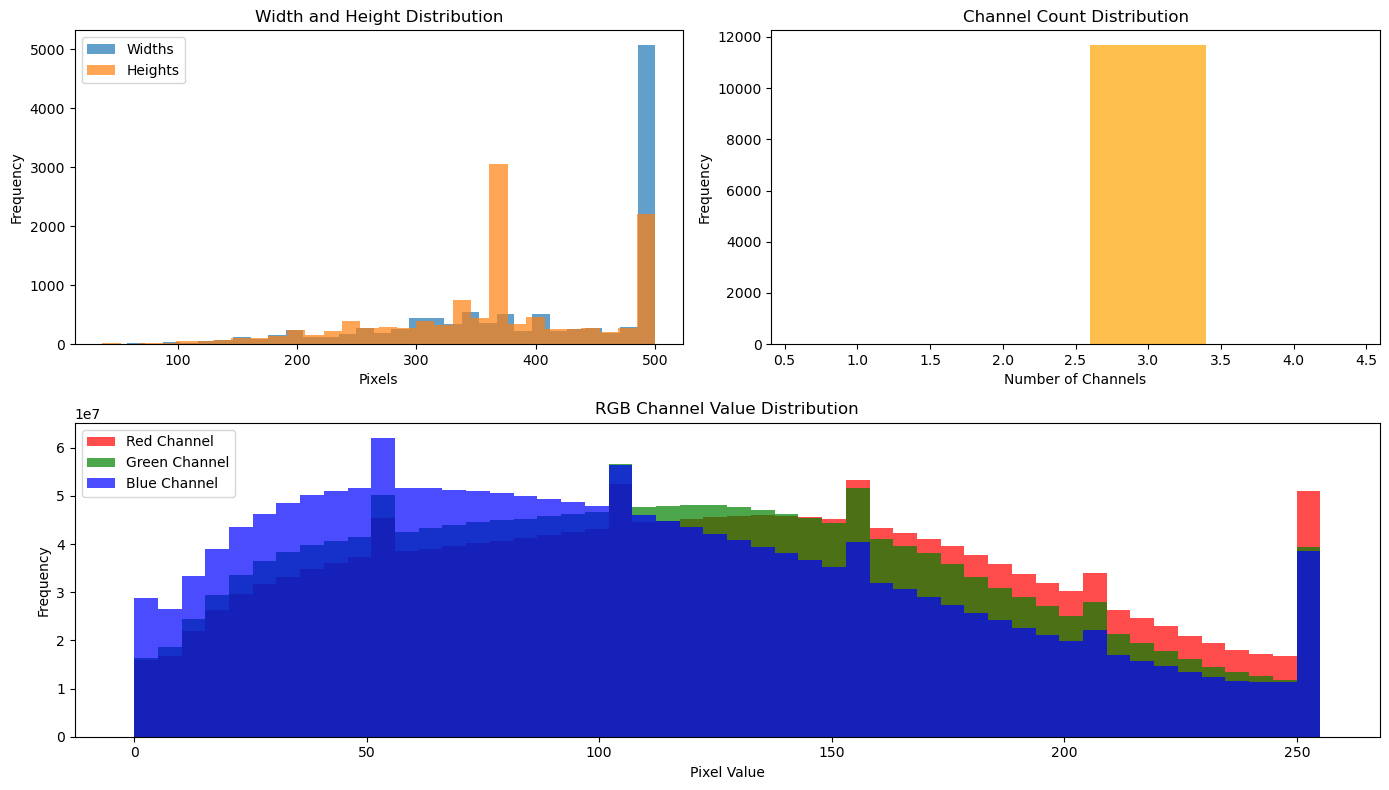

In [12]:
plot_distributions(dims_dog[0], dims_dog[1])

In [13]:
dims_cat = get_image_data('PetImages/Cat')

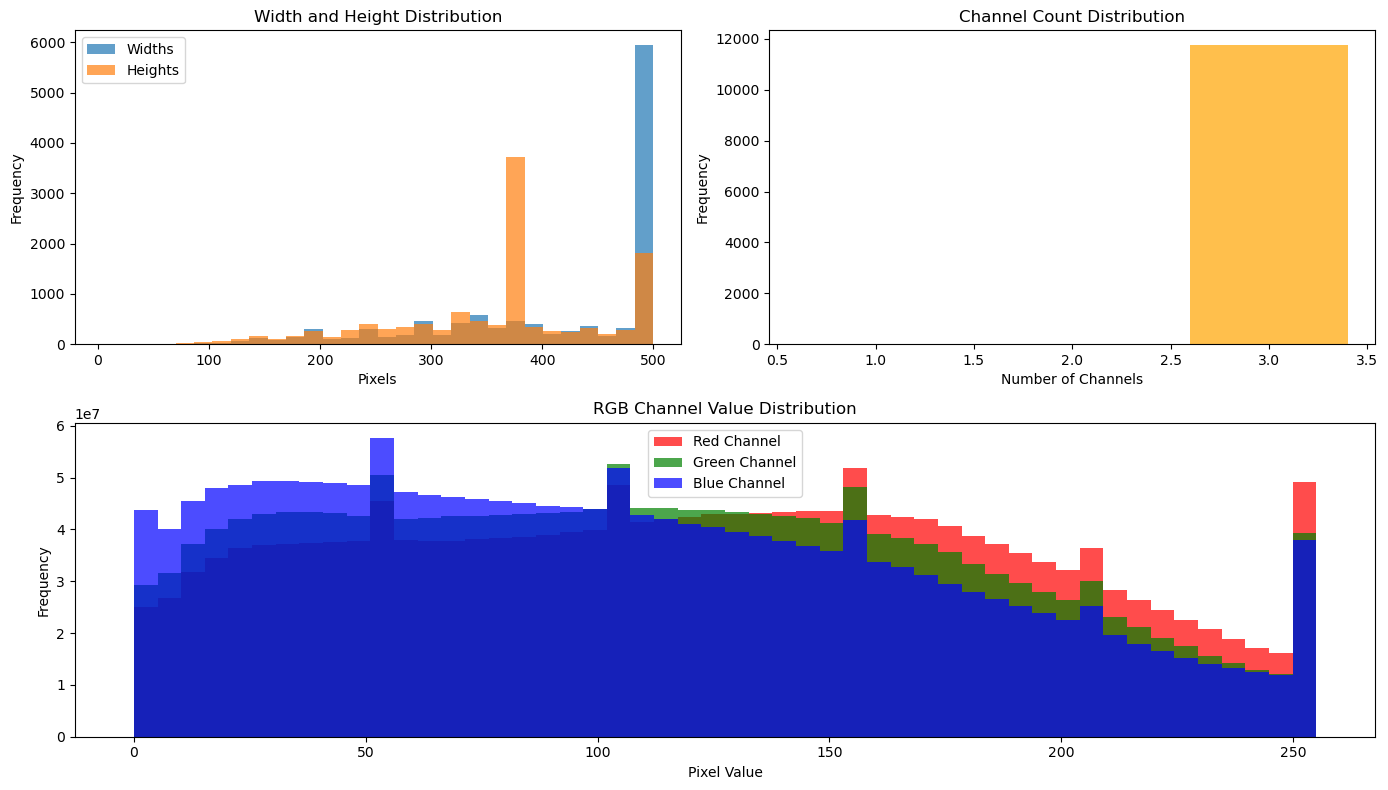

In [15]:
plot_distributions(dims_cat[0],dims_cat[1])

For both classes, then, we have three channels (Red, Green, Blue) and the most common dimensions are 380x500, roughly.

Much as tabular data needs to be cleaned, image data needs to be standardized in order to play nicely with the machine learning algorithims we're using. This will be handled using a built-in Keras utility.

# Generate the Dataset

The [`image_dataset_from_directory` function](https://keras.io/api/data_loading/image/) that we use below is a powerful tool for expediting the pre-processing of image data.

```python
keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
```

The key default settings for our immediate purposes are the `directory` and `labels` parameters.

*   `Directory` is the path of the directory where the images are.
*   `Labels` tells keras how to assign the labels for the dataset. If `labels` is set to `inferred` then the directory should contain subdirectories whose names are the class names. The directories are read in alphanumeric order and the class labels are assigned that way too.

So if your directory is structured like this:
```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Class A will be assigned `0` for its label, and Class B will be assigned `1`. In our case, then, `Cat` will be `0` and `Dog` will be `1`.

If you are not using the directory structure to sort your labels, the labels must be provided to the `labels` parameter in the same order (alphanumeric sort in ascending order) of the examples. (Needless to say, this could be a very time consuming process.)

The code below puts the `image_dataset_from_directory` function to work, splitting the data into training and validation sets along the way.

In addition, parameters `image_size` and `batch_size` enable us to shrink the images we're working with and reduce the number of images kept in memory at any one time, respectively.

In [16]:
image_size = (180, 180)  # Target dimensions for resizing images (height, width).
batch_size = 32  # Number of images processed in a single batch during training.
# Note: A batch size of 128 (common in other setups) may exceed Colab's memory limits, causing crashes.
# The chosen batch size of 32 balances memory usage and runtime, with an estimated runtime of ~3 hours.

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",             # Path to the directory containing the dataset.
    validation_split=0.2,    # Specify that 20% of the dataset will be used for validation.
    subset="both",           # Create both training and validation datasets from the directory.
    seed=42,                 # Random seed to ensure reproducibility when shuffling the data.
    image_size=image_size,   # Resize all images to the specified dimensions (180x180).
    batch_size=batch_size,   # Divide the dataset into batches of the specified size (32 images per batch).
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


The `image_dataset_from_directory` function here:
- Automatically reads images from the directory structure.
- Assumes subdirectories represent class labels (e.g., "Cat", "Dog").
- Splits the data into training and validation subsets based on `validation_split` and `subset`.
- Resizes images to the target `image_size` to ensure uniformity across the dataset.
- Returns two datasets:
   - `train_ds`: The training dataset (80% of the data).
   - `val_ds`: The validation dataset (20% of the data).

# Dataset Visualization
Let's take a look at the dataset we built.


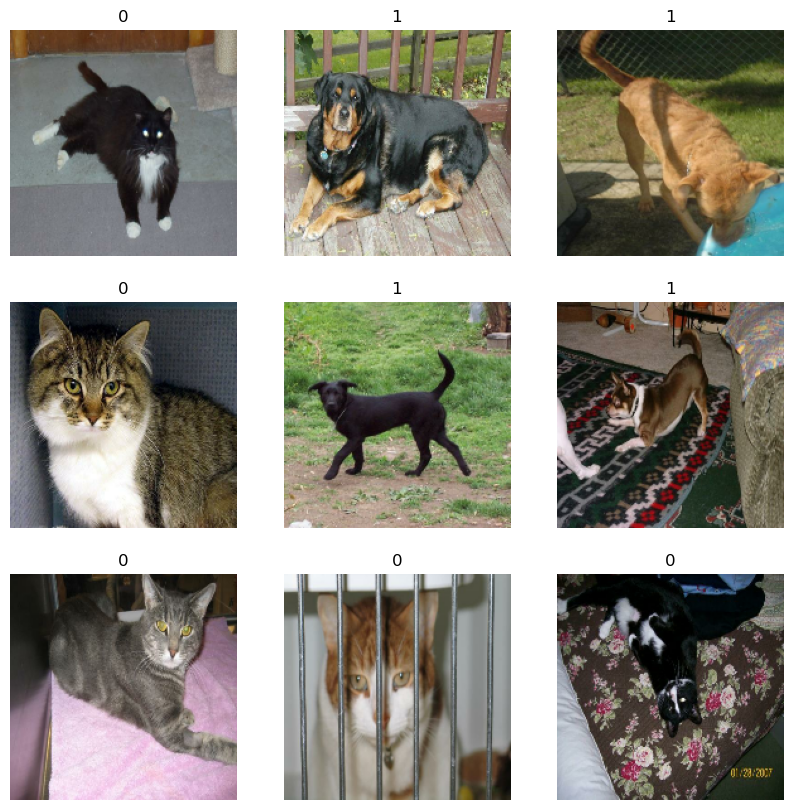

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Remember that the labels here are the true labels. We haven't done any prediction yet.

## Aside: Another Big Challenge of Image Data
Despite the volume of images flooding the Internet, we don't always have enough images to build an effective model. Fortunately, there are viable built-in methods for avoiding the overfitting this creates. We call this "image data augmentation."

Basically, we rotate, shade, or flip the images we do have in order to give our algorithm more data to look at. (If you think this invalidates the model's ability, think about whether you could recognize a picture of a cat, even if it was upside down.)

We can also use the same techniques to expand the size of data we have at our disposal. Note that an augmentation layer in a neural network, such as we are using here, does not increase the size of our dataset. This layer is only used to avoid overfitting.


In [18]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


Let's take a quick look at what this augmentation might look like. We'll apply that augmentation layer to the first few images in our dataset.

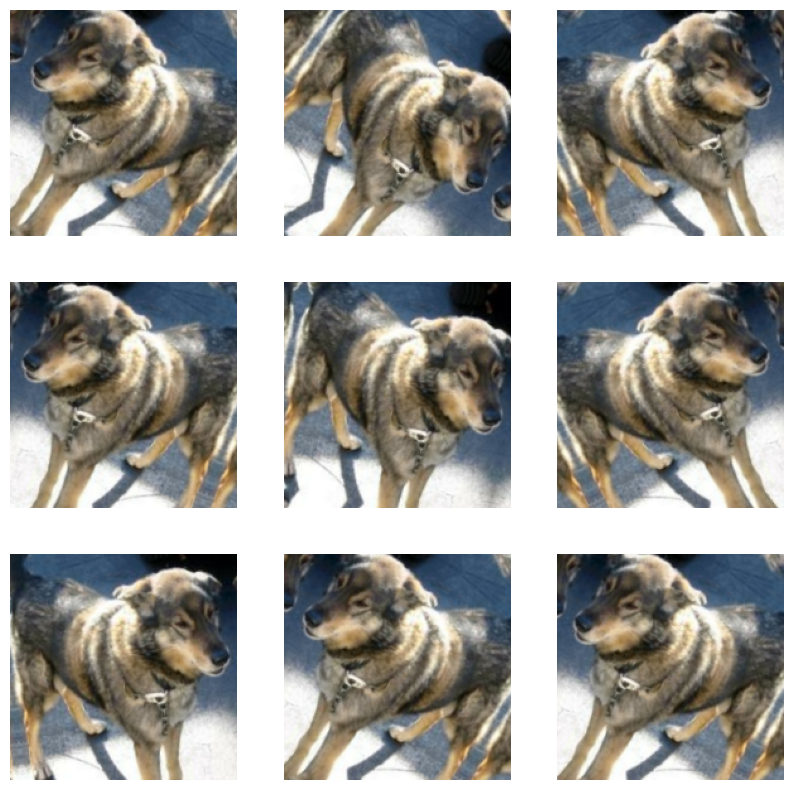

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


The images are clearly of the same animal, but the image itself has been subtly altered to generate valid, but different, images.

# Additional Preprocessing

We have already standarized the shape of our data to 180x180, but the color channels are in the [0,255] range standard for color images. Neural networks prefer smaller input values, so we are going to standardize the channels to be in the [0,1] range with a rescaling layer.

We actually have two options. We can build it into the model, which means that scaling will happen with the rest of the model's execution. This is great if you've got a GPU to work with. Or we can build it into the dataset, which will yield batched augmentations. This is better for a CPU; we're going with option 2.

```python
# Option 1: Built In Standardization
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

```python
# Option 2: Batch it with the dataset
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

In [20]:
# Option 2 Implemented
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Build the Model

We're following a slightly different pattern than you may have seen before, building several different models at one time for a variety of sizes. This is a smaller version of the Xception network, a very powerful image classification network built by Google. This is a convolutional neural network (CNN) model with residual connections, separable convolutions, and batch normalization.
It dynamically adjusts for binary or multi-class classification tasks.
Key architectural elements include entry blocks, repeated feature extraction blocks with residuals, and a global average pooling and dense output layer.
It uses dropout to prevent overfitting and ensures numerical stability with batch normalization.


In [27]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Define the input layer with the specified shape.

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    # Rescale pixel values from [0, 255] to [0, 1] by dividing by 255 for normalization.

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    # Apply a convolutional layer with 128 filters, a 3x3 kernel, stride of 2, and "same" padding.
    # This reduces the spatial dimensions of the input image.

    x = layers.BatchNormalization()(x)
    # Normalize the activations from the previous layer to stabilize and accelerate training.

    x = layers.Activation("relu")(x)
    # Apply ReLU (Rectified Linear Unit) activation to introduce non-linearity.

    previous_block_activation = x
    # Save the output of the entry block for residual connections.

    for size in [256, 512, 728]:
        # Loop through a series of blocks with increasing filter sizes (256, 512, 728).

        x = layers.Activation("relu")(x)
        # Apply ReLU activation to the current block's input.

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # Apply a depthwise separable convolution with the specified number of filters and 3x3 kernel.

        x = layers.BatchNormalization()(x)
        # Normalize the activations after the convolution.

        x = layers.Activation("relu")(x)
        # Apply ReLU activation again.

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # Apply another depthwise separable convolution with the same filter size.

        x = layers.BatchNormalization()(x)
        # Normalize the activations again.

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # Apply a 3x3 max pooling layer with a stride of 2 to reduce the spatial dimensions.

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        # Apply a 1x1 convolution to the previous block's output to match dimensions for addition.

        x = layers.add([x, residual])
        # Add the residual connection to the current block's output.

        previous_block_activation = x
        # Update the residual reference for the next block.

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    # Apply a depthwise separable convolution with 1024 filters and 3x3 kernel.

    x = layers.BatchNormalization()(x)
    # Normalize the activations.

    x = layers.Activation("relu")(x)
    # Apply ReLU activation.

    x = layers.GlobalAveragePooling2D()(x)
    # Apply global average pooling to reduce each feature map to a single value.

    if num_classes == 2:
        units = 1
        # If it's a binary classification task, the output layer will have one unit.
    else:
        units = num_classes
        # For multi-class classification, the output layer will have one unit per class.

    x = layers.Dropout(0.25)(x)
    # Apply dropout with a rate of 25% to reduce overfitting.

    outputs = layers.Dense(units, activation=None)(x)
    # Define the output layer with `units` neurons. No activation is applied here (logits are returned).

    return keras.Model(inputs, outputs)
    # Create and return the Keras model.

# Create the model instance.
model = make_model(input_shape=image_size + (3,), num_classes=2)
# Call `make_model` with input shape (180, 180, 3) (for RGB images) and binary classification (2 classes).

keras.utils.plot_model(model, show_shapes=True)
# Visualize the model's architecture with layer shapes using Keras's plot_model utility.

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Train the Model
Finally, we get to the training. As you have probably been told by now: cleaning and preprocessing the data is 80% of the work of being a machine learning engineer or data scientist.

TIP: If training is taking too long, or exhausts system resources, make the `batch_size` parameter in the `image_dataset_from_directory` function smaller. The batch size seems to be the fastest way to reduce the RAM requirements of training.

In [28]:
epochs = 12

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/12
115/586 ━━━━━━━━━━━━━━━━━━━━ 35:16 4s/step - acc: 0.6174 - loss: 0.6735

KeyboardInterrupt: 

# Try It On New-Ish Data

One thing to point out is that when inference happens, as you'd expect, the data augmentation layer and dropout nodes do not operate.

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Image Processing: Multi-Label Classification

We've covered simple classification, where an image is identified as having one characteristic, like cats and dogs. And we can extend this workflow to include a multi-class problem, say `Cat`, `Dog`, and `Fish`. But many images, most images probably, contain multiple things or traits.

Think of pictures from a fashion show. You could build a classifier that identifies whether the model is male or female; or one that identifies a suit or a dress. But what if you worked for a men's fashion company and wanted to identify both "man" and "suit" in the image? This would be a case of multi-label classification.

**Multi-class Classification**: The data labels contain at least two classes that are mutually exclusive. If an image contains a Dog, it cannot contain a Cat, and vice versa.

**Multi-Label Classification**: The data labels contain at least two classes that are NOT mutually exclusive. Any observation has AT LEAST one label associated with it, but could conceivably have all of them.

Multi-label classification is, in many ways, just an extension of simple classification. The trick is that there's no handy built-in method for associating the labels with the images in question. We have to build a bit of a pipeline using new-ish tools.

# The Dataset
The dataset we're using for multi-label classification is a collection of movie posters collected from IMDB. The labels are one-hot encoded to represent various film genres.

The original form of the dataset is here: https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html.

> Wei-Ta Chu and Hung-Jui Guo, “Movie Genre Classification based on Poster Images with Deep Neural Networks,” Proceedings of International Workshop on Multimodal Understanding of Social, Affective and Subjective Attributes, pp. 39-45, 2017. (in conjunction with ACM Multimedia 2017)











However, the original dataset requires some preprocessing to get into a workable format for our purposes. The link below connects to a zip file that has all the information we need.

NOTE: the zip file of the dataset is stored here: https://www.kaggle.com/datasets/raman77768/movie-classifier. You will need to log in to kaggle, download the dataset, and upload it again to your own Google Drive, and unpack it there. This will likely take a while.

In [ ]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/movie_data/" # Replace with path to your own version of the data
image_dir = data_path + "Images/"

In [ ]:
df = pd.read_csv(data_path + "train.csv")

In [ ]:
df.head()

Let's take a look at some of the images.

In [ ]:

# Take a look at the first three posters in the DataFrame

jpg_files = ["tt0086425.jpg", "tt0085549.jpg", "tt0086465.jpg",]

# Load the first three images and their genres
images = []
titles = []
for file in jpg_files:
    # Extract the filename without extension
    file_name = os.path.splitext(file)[0]

    # Append the opened image to a list of images
    images.append(Image.open(os.path.join(image_dir, file)))

    # Grab the genre(s) of the film associated with the title (calling 'genre' title here because it simplifies things)
    title = df[df['Id']==file_name]['Genre']

    # Append the genre as the title for matplotlib
    titles.append(title)

# Plot the images in a 1x3 matrix
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images[i])
    ax.axis('off')  # Hide axes for better visual appeal
    ax.set_title(titles[i])

plt.tight_layout()
plt.show();

These labels seem to line up pretty well with the movies of the posters. We're going to do a little bit of EDA, just to see what genres we have and how they are represented.

In [ ]:
eda_df = df.drop(['Id', 'Genre'], axis=1)

In [ ]:
eda_column_sums = eda_df.sum().sort_values(ascending=False)

In [ ]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(eda_column_sums.index, eda_column_sums.values)
plt.xlabel('Categories')
plt.ylabel('Sum')
plt.title('Histogram of Column Sums')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

In [ ]:
df.Genre.value_counts()

In [ ]:
value_counts = df.Genre.value_counts()[:10]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(value_counts.index.astype(str), value_counts.values)
plt.xlabel('Values')
plt.ylabel('Counts')
plt.title("Value Counts of Mult-Label Genres")
plt.xticks(rotation=75)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()

# An Aside: EDA with Images

It may seem like working with images removes the need to do any kind of EDA. Images are just images, right? Wrong! As these two examples show, it is definitely possible to do EDA on images. It falls into two processes: the images themselves and the labels.

In the first example, the Cats and Dogs dataset, we took a very quick look at the shapes, sizes, and colors of the images as statistical abstractions (their heights, widths, colors, channels). And we looked at the images proper.

In this second example, we examined the labels for the data. Both of these processes are necessary and useful EDA when working with images. Knowing the shapes and sizes of images helps us configure the neural networks and the standardizations that we need to perform. Understanding the distributions of labels or other metadata can help us better understand what we are trying to predict and maybe find ways to expedite the labeling process.

# Back to work: Preprocessing Images and Labels
Unlike the Cats and Dogs example, we don't have a handy built in function that takes care of dataset construction for us. We have to build out our dataset more manually and assign the labels to the images so that we can train the model.

You may recall from earlier discussions of image processing that computers see images as arrays of numbers, with each element (number) in the array representing the shade and color of a pixel. Keras, fortunately, does have tools for converting the image files to numpy arrays that we can then associate with the `df` containing the labels.

In other words, we're going to turn those lovely posters into `DataFrames`!

You'll note that we're using the [`tqdm` package](https://tqdm.github.io/) here as well. If you haven't seen this little beauty before, it provides a smart progress bar for just about any iterable in Python. It's a fantastic helper for large processing jobs, which is frequently the case when working with images.

As noted earlier, neural networks require lots of examples to learn effectively. Although the images themselves might be small individually, the volume we need eats into system resources surprisingly quickly; reading the full dataset into Colab will exhaust the free tier's resources very quickly.

We will discuss some more rigorous methods of downsampling data in another lesson, but for now we're going to limit our data to the first 2500 observations, and we're going to compress our images down signficantly.

In [ ]:
df = df.head(2500).copy(deep=True)

In [ ]:
width = 180
height = 180
X = []
for i in tqdm(range(df.shape[0])):
  path = data_path + 'Images/' + df['Id'][i] + '.jpg'
      # Construct the file path for the current image using the `Id` column from the DataFrame.

  img = image.load_img(path, target_size=(width, height, 3))
  # Load the image file from the constructed path.
  # Resize the image to the target dimensions (180x180) with 3 channels (RGB).

  img = image.img_to_array(img)
  # Convert the loaded image into a NumPy array for numerical processing.

  img = img / 255.0
  # Normalize the pixel values to the range [0, 1] by dividing by 255.0.
  # This is a common preprocessing step for deep learning models to improve training stability.

  X.append(img)
  # Append the processed image array to the list `X`.

X = np.array(X)
# Convert the list of processed images into a NumPy array.
# This ensures the data is in a format suitable for input to a deep learning model.

In [ ]:
X.shape

Looks like our shapes line up properly. Let's get the labels attached as well.

In [ ]:
y = df.drop(['Id','Genre'],axis=1)
y = y.to_numpy()
y.shape


And now we split our data for validation.

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# Build the Model
From here on out it's the usual neural network with convolutional layers.

In [ ]:
# Initialize a Sequential model, which allows layers to be added one after another.
model = Sequential()

# Add an Input layer, specifying the shape of a single training example (e.g., an image).
model.add(keras.Input(shape=X_train[0].shape))

# Add the first convolutional layer with 16 filters, a 3x3 kernel, and ReLU activation.
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
# This layer detects basic features like edges and corners in the input image.

# Add a Batch Normalization layer to normalize the output of the Conv2D layer.
model.add(BatchNormalization())
# This stabilizes and accelerates training by reducing internal covariate shift.

# Add a MaxPooling layer to reduce spatial dimensions by taking the maximum value in 2x2 regions.
model.add(MaxPool2D(2, 2))
# This reduces computational complexity and focuses on the most prominent features.

# Add a Dropout layer to randomly drop 30% of neurons during training.
model.add(Dropout(0.3))
# This helps prevent overfitting by reducing reliance on specific neurons.

# Add the second convolutional block (Conv2D -> BatchNormalization -> MaxPooling -> Dropout).
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# Increase the number of filters to 32 for detecting more complex features.
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3))

# Add the third convolutional block with 64 filters.
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Further increases the number of filters to detect even more complex patterns.
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.4))  # Increase dropout rate to 40% to further reduce overfitting risk.

# Flatten the output of the previous layer to convert the 3D feature maps into a 1D vector.
model.add(Flatten())
# This prepares the data for input into dense (fully connected) layers.

# Add a Dense (fully connected) layer with 128 neurons and ReLU activation.
model.add(Dense(128, activation='relu'))
# This layer learns high-level combinations of the features extracted by the Conv2D layers.
model.add(BatchNormalization())  # Normalize the output to stabilize training.
model.add(Dropout(0.5))  # Apply a 50% dropout rate for strong regularization.

# Add the final Dense layer with 25 neurons and sigmoid activation.
model.add(Dense(25, activation='sigmoid'))
# The output layer has 25 neurons, each representing a class in a multi-label classification problem.
# Sigmoid activation is used to output probabilities for each class, as multiple classes can be "on."

# The model is now ready to be compiled and trained.

And the model summary tells us what we built:

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])

These scores are ... not great. There are a few explanations for the badness, though. We've got few epochs for training, and we can see from the charts below that things do get better as the number of epochs increases. This is pretty standard for neural networks. If we were to increase the number of epochs, we would expect Loss to fall and Accuracy to rise further. We are also using smaller batches (default of 32), and only about half the dataset, due to system constraints.

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

In [ ]:
plotLearningCurve(history,5)

# Try it out!

In [ ]:
img = image.load_img(data_path + 'Images/tt0088247.jpg',target_size=(width,height,3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1,width,height,3)
classes = df.columns[2:]
y_pred = model.predict(img)
top3=np.argsort(y_pred[0])[:-4:-1]
for i in range(3):
  print("Label: ", classes[top3[i]], "-- Probability: ", round(y_pred[0][top3[i]], 3))

The Terminator (1984) is here judged at being most likely to be a Thriller, followed by Action, and then Horror. The first hit on a google search for The Terminator shows Action/Sci-Fi. But the margins on our predictions are very fine and we might get something different if we increase the epochs and training times.

# Conclusion
In this notebook, we have done three main things. First, we have actually conducted EDA on image data, looking bot at the labels and annotations and the images themselves. (We have only barely touched on the PIL/Pillow libraries which are extremely handy for doing that kind of work.) Second, we have worked through two common problem types in computer vision: simple classifcation and multi-label classification. Third, and finally, we have surfaced (and covered strategies for dealing with) one of the biggest challenges in working with images in particular and deep learning in general: size and system constraints.